In [4]:
%matplotlib inline
import torch
from config import Config_MBM_EEG
from mae_for_eeg import *
from eeg_dataset import EEGDataset
import yaml
from torch.utils.data import DataLoader
configs= yaml.load(open("/mnt/nvme/node02/pranav/AE24/AudioLDM-training-finetuning/audioldm_train/config/2023_08_23_reproduce_audioldm/audioldm_eeg.yaml", "r"), Loader=yaml.FullLoader)
dataset = EEGDataset(configs,split="train")
loader = DataLoader(dataset, shuffle=False,batch_size =3)

/mnt/nvme/node02/pranav/AE24/AudioLDM-training-finetuning/audioldm_train/utilities/audio/stft.py:42: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/mnt/nvme/node02/pranav/AE24/AudioLDM-training-finetuning/audioldm_train/utilities/audio/stft.py:145: FutureWarning: Pass sr=16000, n_fft=1024, n_mels=64, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


In [2]:
ckpt= "/mnt/nvme/node02/pranav/AE24/DreamDiffusion/dreamdiffusion/results/eeg_pretrain/21-11-2023-05-58-07/checkpoints/checkpoint.pth"

lopi=torch.load(ckpt,map_location='cpu')

config =Config_MBM_EEG()
model = MAEforEEG(time_len=512, patch_size=config.patch_size, embed_dim=config.embed_dim,
                decoder_embed_dim=config.decoder_embed_dim, depth=config.depth, 
                num_heads=config.num_heads, decoder_num_heads=config.decoder_num_heads, mlp_ratio=config.mlp_ratio,
                focus_range=config.focus_range, focus_rate=config.focus_rate, 
                img_recon_weight=config.img_recon_weight, use_nature_img_loss=config.use_nature_img_loss)  
model.load_state_dict(lopi["model"],strict=False)

<All keys matched successfully>

In [5]:
import torch.nn as nn
from audioldm_train.modules.clap.open_clip import create_model
from audioldm_train.modules.clap.training.data import get_audio_features
import torchaudio
import torch.optim as optim
import torch
from config import Config_MBM_EEG
from mae_for_eeg import *
from eeg_dataset import EEGDataset
# from audioldm_train.utilities.data.dataset import AudioDataset

import yaml
from torch.utils.data import DataLoader





In [6]:
class EEG2Latent(nn.Module):
    def __init__(self):
        super(EEG2Latent,self).__init__()


        ckpt= "/mnt/nvme/node02/pranav/AE24/DreamDiffusion/dreamdiffusion/results/eeg_pretrain/21-11-2023-05-58-07/checkpoints/checkpoint.pth"

        state_dict=torch.load(ckpt,map_location='cpu')
        config =Config_MBM_EEG()

        self.eeg_encoder = eeg_encoder(512,4,512,64,24,16,1)
        self.eeg_encoder.load_state_dict(state_dict,strict=False)

        for param in self.eeg_encoder.parameters():
            param.requires_grad =False
        

        self.eeg_projection = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(128*512,512),
            nn.ReLU(),
            nn.Linear(512,512),
        )

    def forward(self,x):
        x=self.eeg_encoder.forward(x.permute(0,2,1))
        x=self.eeg_projection(x)
        return x






In [5]:
from transformers import (
    RobertaTokenizer,
    AutoTokenizer,
    T5EncoderModel,
    MT5EncoderModel,
)


class CLAPAudioEmbedding(nn.Module):
    def __init__(
        self,
        pretrained_path="/mnt/nvme/node02/pranav/AE24/AudioLDM-training-finetuning/data/checkpoints/clap_music_speech_audioset_epoch_15_esc_89.98.pt",
        sampling_rate=16000,
        embed_mode="audio",
        amodel="HTSAT-base",
        unconditional_prob=0.1,
        random_mute=False,
        max_random_mute_portion=0.5,
        training_mode=True,
    ):
        super().__init__()
        self.device = "cpu"
        self.precision = "fp32"
        self.amodel = amodel  # or 'PANN-14'
        self.tmodel = "roberta"  # the best text encoder in our training
        self.enable_fusion = False  # False if you do not want to use the fusion model
        self.fusion_type = "aff_2d"
        self.pretrained = pretrained_path
        self.embed_mode = embed_mode
        self.embed_mode_orig = embed_mode
        self.sampling_rate = sampling_rate
        self.unconditional_prob = unconditional_prob
        self.random_mute = random_mute
        self.tokenize = RobertaTokenizer.from_pretrained("roberta-base")
        self.max_random_mute_portion = max_random_mute_portion
        self.training_mode = training_mode
        self.model, self.model_cfg = create_model(
            self.amodel,
            self.tmodel,
            self.pretrained,
            precision=self.precision,
            device=self.device,
            enable_fusion=self.enable_fusion,
            fusion_type=self.fusion_type,
        )
        audio_cfg = self.model_cfg["audio_cfg"]
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=audio_cfg["sample_rate"],
            n_fft=audio_cfg["window_size"],
            win_length=audio_cfg["window_size"],
            hop_length=audio_cfg["hop_size"],
            center=True,
            pad_mode="reflect",
            power=2.0,
            norm=None,
            onesided=True,
            n_mels=64,
            f_min=audio_cfg["fmin"],
            f_max=audio_cfg["fmax"],
        )
        for p in self.model.parameters():
            p.requires_grad = False
        self.unconditional_token = None
        self.model.eval()

    def get_unconditional_condition(self, batchsize):
        self.unconditional_token = self.model.get_text_embedding(
            self.tokenizer(["", ""])
        )[0:1]
        return torch.cat([self.unconditional_token.unsqueeze(0)] * batchsize, dim=0)

    def batch_to_list(self, batch):
        ret = []
        for i in range(batch.size(0)):
            ret.append(batch[i])
        return ret

    def make_decision(self, probability):
        if float(torch.rand(1)) < probability:
            return True
        else:
            return False

    def random_uniform(self, start, end):
        val = torch.rand(1).item()
        return start + (end - start) * val

    def _random_mute(self, waveform):
        # waveform: [bs, t-steps]
        t_steps = waveform.size(-1)
        for i in range(waveform.size(0)):
            mute_size = int(
                self.random_uniform(0, end=int(t_steps * self.max_random_mute_portion))
            )
            mute_start = int(self.random_uniform(0, t_steps - mute_size))
            waveform[i, mute_start : mute_start + mute_size] = 0
        return waveform

    def cos_similarity(self, waveform, text):
        # waveform: [bs, t_steps]
        original_embed_mode = self.embed_mode
        with torch.no_grad():
            self.embed_mode = "audio"
            audio_emb = self(waveform.cuda())
            self.embed_mode = "text"
            text_emb = self(text)
            similarity = F.cosine_similarity(audio_emb, text_emb, dim=2)
        self.embed_mode = original_embed_mode
        return similarity.squeeze()

    def build_unconditional_emb(self):
        self.unconditional_token = self.model.get_text_embedding(
            self.tokenizer(["", ""])
        )[0:1]
    def tokenizer(self, text):
        result = self.tokenize(
            text,
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt",
        )
        return {k: v.squeeze(0) for k, v in result.items()}


    def forward(self, batch):
        # If you want this conditioner to be unconditional, set self.unconditional_prob = 1.0
        # If you want this conditioner to be fully conditional, set self.unconditional_prob = 0.0
        if self.model.training == True and not self.training_mode:
            print(
                "The pretrained CLAP model should always be in eval mode. Reloading model just in case you change the parameters."
            )
            self.model, self.model_cfg = create_model(
                self.amodel,
                self.tmodel,
                self.pretrained,
                precision=self.precision,
                device="cuda",
                enable_fusion=self.enable_fusion,
                fusion_type=self.fusion_type,
            )
            for p in self.model.parameters():
                p.requires_grad = False
            self.model.eval()

        # if self.unconditional_token is None:
        #     self.build_unconditional_emb()

        # if(self.training_mode):
        #     assert self.model.training == True
        # else:
        #     assert self.model.training == False

        # the 'fusion' truncate mode can be changed to 'rand_trunc' if run in unfusion mode
        if self.embed_mode == "audio":
            # if not self.training:
            #     print("INFO: clap model calculate the audio embedding as condition")
            with torch.no_grad():
                # assert (
                #     self.sampling_rate == 16000
                # ), "We only support 16000 sampling rate"

                # if self.random_mute:
                #     batch = self._random_mute(batch)
                # batch: [bs, 1, t-samples]
                if self.sampling_rate != 48000:
                    batch = torchaudio.functional.resample(
                        batch, orig_freq=self.sampling_rate, new_freq=48000
                    )

                audio_data = batch.squeeze(1)
                mel = self.mel_transform(audio_data)
                audio_dict = get_audio_features(
                    audio_data,
                    mel,
                    380000,
                    data_truncating="fusion",
                    data_filling="repeatpad",
                    audio_cfg=self.model_cfg["audio_cfg"],
                )
                
                # [bs, 512]
                embed = self.model.get_audio_embedding(audio_dict)
        elif self.embed_mode == "text":
            with torch.no_grad():
                # the 'fusion' truncate mode can be changed to 'rand_trunc' if run in unfusion mode
                text_data = self.tokenizer(batch)

                if isinstance(batch, str) or (
                    isinstance(batch, list) and len(batch) == 1
                ):
                    for key in text_data.keys():
                        text_data[key] = text_data[key].unsqueeze(0)

                embed = self.model.get_text_embedding(text_data)

        embed = embed.unsqueeze(1)
        # for i in range(embed.size(0)):
        #     if self.make_decision(self.unconditional_prob):
        #         embed[i] = self.unconditional_token
        # embed = torch.randn((batch.size(0), 1, 512)).type_as(batch)
        return embed.detach()





In [42]:
configs= yaml.load(open("/mnt/nvme/node02/pranav/AE24/AudioLDM-training-finetuning/audioldm_train/config/2023_08_23_reproduce_audioldm/audioldm_eeg.yaml", "r"), Loader=yaml.FullLoader)
dataset = EEGDataset(configs,split="train")
loader = DataLoader(dataset, shuffle=False,batch_size =100)
# from audioldm_train.train.load_audio import audioDa
# auloader = DataLoader(audioDa, shuffle=False,batch_size =10)
# audiodata=next(iter(auloader))

/mnt/nvme/node02/pranav/AE24/AudioLDM-training-finetuning/audioldm_train/utilities/audio/stft.py:42: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/mnt/nvme/node02/pranav/AE24/AudioLDM-training-finetuning/audioldm_train/utilities/audio/stft.py:145: FutureWarning: Pass sr=16000, n_fft=1024, n_mels=64, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


In [36]:
import torch
# import torch.distributed as dist
# from torch.nn.parallel import DistributedDataParallel as DDP
# dist.init_process_group(backend='nccl')
checkpoint_path="/mnt/nvme/node02/pranav/AE24/AudioLDM-training-finetuning/audioldm_train/modules/eeg_encoder/models/eegLatentmodel_test.pth"
checkpoint_path="/mnt/nvme/node02/pranav/AE24/starDuck/CAPE/models/eegLatentmodel_Linfonce.pth"
eeg_model= EEG2Latent()
eegmodel= torch.load(checkpoint_path,map_location=torch.device('cpu'))
eeg_model.load_state_dict(eegmodel)

In [7]:


audio_model = CLAPAudioEmbedding()
audio_model.eval()
audio_model.embed_mode="audio"
eeg_model= EEG2Latent()

optimizer = optim.Adam(eeg_model.parameters(), lr=0.001)
cosine = nn.CosineSimilarity()

from tqdm import tqdm

numEpochs=1
for epoch in range(numEpochs):
    sum_loss=0
    for batch in tqdm(loader):
        optimizer.zero_grad()
        eeglatent = eeg_model(batch["eeg"])
        with torch.no_grad():
            audiolatent = torch.squeeze(audio_model(batch["waveform"]))

        loss = (1- cosine(eeglatent,audiolatent)).mean()
        sum_loss+=loss
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

    print(f"Training loss: {sum_loss/len(loader)} ")


/home/pranav/miniconda3/envs/ae24/lib/python3.10/site-packages/torchlibrosa/stft.py:193: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = librosa.util.pad_center(fft_window, n_fft)
/home/pranav/miniconda3/envs/ae24/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSeque

In [41]:
audiodata["eeg"].shape,audiodata["waveform"].shape

(torch.Size([10, 655, 64]), torch.Size([10, 1, 163750]))

In [22]:
cosine(audiolatent,eeglatent)

NameError: name 'audiolatent' is not defined

In [43]:
loader = DataLoader(dataset, shuffle=False,batch_size =10)
audiodata = next(iter(loader))
ee = eeg_model(audiodata["eeg"])

/mnt/nvme/node02/pranav/AE24/starDuck/CAPE/eeg_dataset.py:252: FutureWarning: Pass sr=16000, n_fft=1024, n_mels=64, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa_mel_fn(


In [47]:
30*15/60



7.5

In [44]:
audiodata["eeg"].shape

torch.Size([10, 512, 64])

In [17]:
audio_model = CLAPAudioEmbedding()
audio_model.embed_mode="audio"
ae = torch.squeeze(audio_model(audiodata["waveform"]),dim=1)

/home/pranav/miniconda3/envs/ae24/lib/python3.10/site-packages/torchlibrosa/stft.py:193: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = librosa.util.pad_center(fft_window, n_fft)
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized

In [18]:

audio_model.embed_mode="text"
te = torch.squeeze(audio_model(audiodata["text"]),dim=1)
ae.shape,te.shape

(torch.Size([10, 512]), torch.Size([10, 512]))

In [20]:
cosine = nn.CosineSimilarity()

cosine(ae,te)

tensor([ 0.1998,  0.2578,  0.2446,  0.2426,  0.1279,  0.0878, -0.0385,  0.0282,
         0.1468,  0.1716])

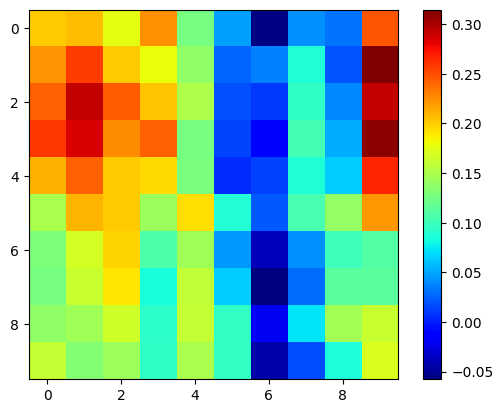

In [21]:
%matplotlib inline
result=ae@te.T
import matplotlib.pyplot as plt


normalized_result = (result - torch.min(result)) / (torch.max(result) - torch.min(result))

# Plotting the result as a color matrix
io=result.numpy()
io.shape

plt.imshow(io,cmap="jet")
plt.colorbar()
plt.show()